In [1]:
import sys
sys.path.insert(1, '../')
import torch
from spiral.analysis import FunctionGenerator, Simulator
import matplotlib.pyplot as plt
from matplotlib_dashboard import MatplotlibDashboard

from spiral import (
    IntegrateAndFireSoma,
    LeakyMembrane,
    LinearDendrite,
    Axon,
    STDP,
    Synapse,
    DisconnectorSynapticCover,
    LeakyResponseFunction,
    AutapseConnectivity,
    ScalingResponseFunction,
    SynapticPlasticityRate,
    Network,
)
LIF = (LeakyMembrane(IntegrateAndFireSoma))
from spiral.operators import *

In [2]:
CONSIDER | Network(dt=1., batch=1)
###################################################
INSERT | LIF(name='pre', shape=(2,), analyzable=True)
INSERT | LIF(name='post', shape=(2,), analyzable=True)
###################################################
INSERT | (
    (
        DisconnectorSynapticCover(Synapse)(
            connectivity_pattern=AutapseConnectivity()
        )
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=1.)
        ) |OF| CONSIDERED.NETWORK['pre']
    ) | TO | (
        LinearDendrite(
            plasticity_model=STDP(
                presynaptic_tagging=LeakyResponseFunction(tau=10, analyzable=True),
                postsynaptic_tagging=LeakyResponseFunction(tau=10, analyzable=True),
                ltp_rate=SynapticPlasticityRate(rate=0.1),
                ltd_rate=SynapticPlasticityRate(rate=0.1),
            ),
            initial_weights=torch.as_tensor([[.5,0.],[0.,.5]]),
            analyzable=True,
        ) |OF| CONSIDERED.NETWORK['post']
    )
)
###################################################
net = CHECKOUT | CONSIDERED.NETWORK
net

Network(
  (pre): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (pre_Axon_0): Axon(
      (response_function): ScalingResponseFunction()
    )
  )
  (post): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (post_LinearDendrite_0): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): LeakyResponseFunction()
        (postsynaptic_tagging): LeakyResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate): SynapticPlasticityRate()
      )
    )
  )
  (SynapseCoveredByDisconnectorSynapticCover_from_pre_Axon_0_to_post_LinearDendrite_0): SynapseCoveredByDisconnectorSynapticCover(
    (connectivity_pattern): AutapseConnectivity()
    (_axon): Axon(
      (response_function): ScalingResponseFunction()
    )
    (_dendrite): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): LeakyResponseFunction()
        (postsynaptic_tagging): LeakyResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate):

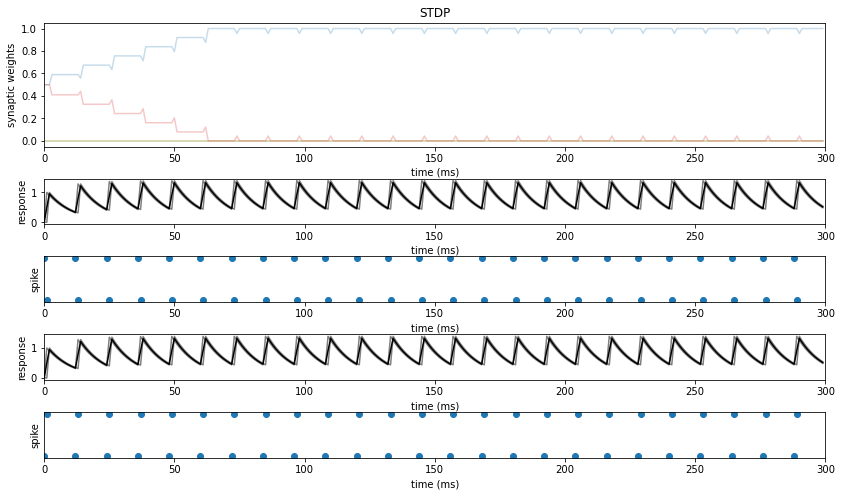

In [3]:
pre_clamps  = torch.tensor([[True,False],[False,True]])
post_clamps = torch.tensor([[False,True],[True,False]])

net.reset()

def run():
    for i in range(2):
        net.progress(external_inputs = {
            'pre' : {'clamps': pre_clamps[i] , 'unclamps': ~pre_clamps[i] },
            'post': {'clamps': post_clamps[i], 'unclamps': ~post_clamps[i]},
        })
    for i in range(10):
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })

sim = Simulator(run)
sim.simulate(times=25)

plt.figure(figsize=(14,8))
md = MatplotlibDashboard([
        ['W'],
        ['W'],
        ['post'],
        ['S2'],
        ['pre'],
        ['S1'],
    ], hspace=.7, wspace=.3)

net['pre'].plot_spikes(md['S1'])
net['post'].plot_spikes(md['S2'])
net['post']['post_LinearDendrite_0'].plot_synaptic_weights(md['W'])
net['post']['post_LinearDendrite_0'].plasticity_model.presynaptic_tagging.plot_response(md['pre'])
net['post']['post_LinearDendrite_0'].plasticity_model.postsynaptic_tagging.plot_response(md['post'])
md['W'].set_title('STDP')
plt.show()

In [4]:
CONSIDER | Network(dt=1., batch=2)
###################################################
INSERT | LIF(name='pre', shape=(2,), analyzable=True)
INSERT | LIF(name='post', shape=(2,), analyzable=True)
###################################################
INSERT | (
    (
        DisconnectorSynapticCover(Synapse)(
            connectivity_pattern=AutapseConnectivity()
        )
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=1.)
        ) |OF| CONSIDERED.NETWORK['pre']
    ) | TO | (
        LinearDendrite(
            plasticity_model=STDP(
                presynaptic_tagging=LeakyResponseFunction(tau=10, analyzable=True),
                postsynaptic_tagging=LeakyResponseFunction(tau=10, analyzable=True),
                ltp_rate=SynapticPlasticityRate(rate=0.1),
                ltd_rate=SynapticPlasticityRate(rate=0.1),
            ),
            initial_weights=torch.as_tensor([[.5,0.],[0.,.5]]),
            analyzable=True,
        ) |OF| CONSIDERED.NETWORK['post']
    )
)
###################################################
net = CHECKOUT | CONSIDERED.NETWORK
net

Network(
  (pre): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (pre_Axon_0): Axon(
      (response_function): ScalingResponseFunction()
    )
  )
  (post): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (post_LinearDendrite_0): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): LeakyResponseFunction()
        (postsynaptic_tagging): LeakyResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate): SynapticPlasticityRate()
      )
    )
  )
  (SynapseCoveredByDisconnectorSynapticCover_from_pre_Axon_0_to_post_LinearDendrite_0): SynapseCoveredByDisconnectorSynapticCover(
    (connectivity_pattern): AutapseConnectivity()
    (_axon): Axon(
      (response_function): ScalingResponseFunction()
    )
    (_dendrite): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): LeakyResponseFunction()
        (postsynaptic_tagging): LeakyResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate):

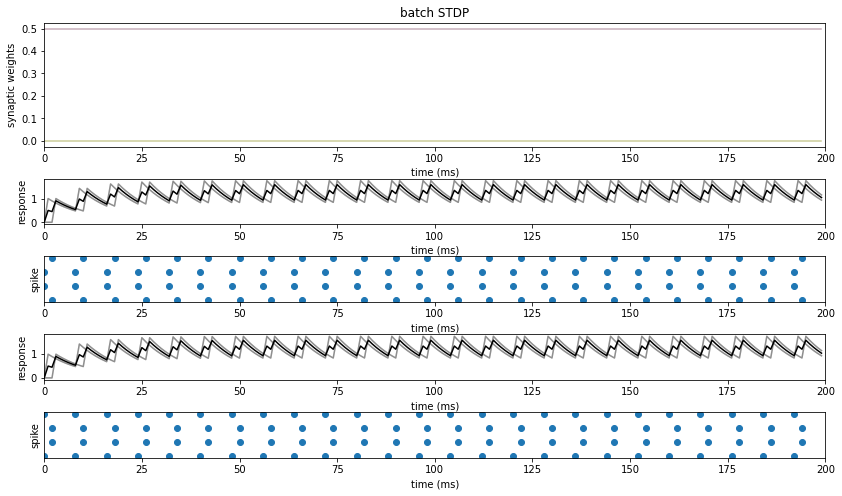

In [5]:
pre_clamps  = torch.tensor([[[True,False],[False,True]],[[False,True],[True,False]]])
post_clamps = torch.tensor([[[False,True],[True,False]],[[True,False],[False,True]]])

net.reset()

def run():
    for i in range(2):
        net.progress(external_inputs = {
            'pre' : {'clamps': pre_clamps[i] , 'unclamps': ~pre_clamps[i] },
            'post': {'clamps': post_clamps[i], 'unclamps': ~post_clamps[i]},
        })
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })
    for i in range(4):
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })

sim = Simulator(run)
sim.simulate(times=25)

plt.figure(figsize=(14,8))
md = MatplotlibDashboard([
        ['W'],
        ['W'],
        ['post'],
        ['S2'],
        ['pre'],
        ['S1'],
    ], hspace=.7, wspace=.3)

net['pre'].plot_spikes(md['S1'])
net['post'].plot_spikes(md['S2'])
net['post']['post_LinearDendrite_0'].plot_synaptic_weights(md['W'])
net['post']['post_LinearDendrite_0'].plasticity_model.presynaptic_tagging.plot_response(md['pre'])
net['post']['post_LinearDendrite_0'].plasticity_model.postsynaptic_tagging.plot_response(md['post'])
md['W'].set_title('batch STDP')
plt.show()

In [6]:
from spiral import FlatResponseFunction

CONSIDER | Network(dt=1., batch=1)
###################################################
INSERT | LIF(name='pre', shape=(2,), analyzable=True)
INSERT | LIF(name='post', shape=(2,), analyzable=True)
###################################################
INSERT | (
    (
        DisconnectorSynapticCover(Synapse)(
            connectivity_pattern=AutapseConnectivity()
        )
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=1.)
        ) |OF| CONSIDERED.NETWORK['pre']
    ) | TO | (
        LinearDendrite(
            plasticity_model=STDP(
                presynaptic_tagging=FlatResponseFunction(),
                postsynaptic_tagging=FlatResponseFunction(),
                ltp_rate=SynapticPlasticityRate(rate=0.1),
                ltd_rate=SynapticPlasticityRate(rate=0.1),
            ),
            initial_weights=torch.as_tensor([[.5,0.],[0.,.5]]),
            analyzable=True,
        ) |OF| CONSIDERED.NETWORK['post']
    )
)
###################################################
net = CHECKOUT | CONSIDERED.NETWORK
net

Network(
  (pre): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (pre_Axon_0): Axon(
      (response_function): ScalingResponseFunction()
    )
  )
  (post): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (post_LinearDendrite_0): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): FlatResponseFunction()
        (postsynaptic_tagging): FlatResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate): SynapticPlasticityRate()
      )
    )
  )
  (SynapseCoveredByDisconnectorSynapticCover_from_pre_Axon_0_to_post_LinearDendrite_0): SynapseCoveredByDisconnectorSynapticCover(
    (connectivity_pattern): AutapseConnectivity()
    (_axon): Axon(
      (response_function): ScalingResponseFunction()
    )
    (_dendrite): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): FlatResponseFunction()
        (postsynaptic_tagging): FlatResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate): Syn

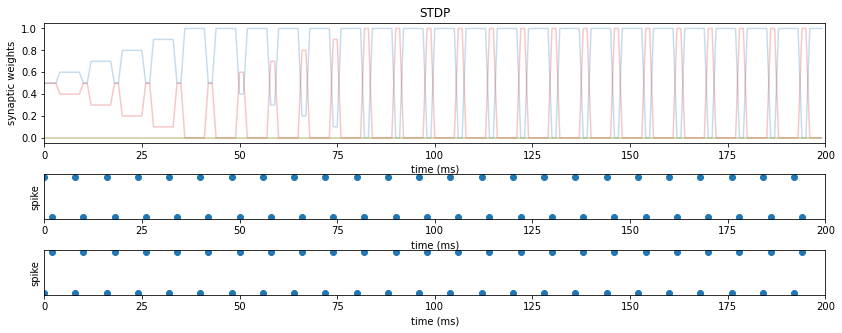

In [7]:
pre_clamps  = torch.tensor([[True,False],[False,True]])
post_clamps = torch.tensor([[False,True],[True,False]])

net.reset()

def run():
    for i in range(2):
        net.progress(external_inputs = {
            'pre' : {'clamps': pre_clamps[i] , 'unclamps': ~pre_clamps[i] },
            'post': {'clamps': post_clamps[i], 'unclamps': ~post_clamps[i]},
        })
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })
    for i in range(4):
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })

sim = Simulator(run)
sim.simulate(times=25)

plt.figure(figsize=(14,5))
md = MatplotlibDashboard([
        ['W'],
        ['W'],
        ['S2'],
        ['S1'],
    ], hspace=.7, wspace=.3)

net['pre'].plot_spikes(md['S1'])
net['post'].plot_spikes(md['S2'])
net['post']['post_LinearDendrite_0'].plot_synaptic_weights(md['W'])
md['W'].set_title('STDP')
plt.show()

In [8]:
from spiral import LimitedFlatResponseFunction

CONSIDER | Network(dt=1., batch=1)
###################################################
INSERT | LIF(name='pre', shape=(2,), analyzable=True)
INSERT | LIF(name='post', shape=(2,), analyzable=True)
###################################################
INSERT | (
    (
        DisconnectorSynapticCover(Synapse)(
            connectivity_pattern=AutapseConnectivity()
        )
    ) | FROM | (
        Axon(
            response_function=ScalingResponseFunction(scale=1.)
        ) |OF| CONSIDERED.NETWORK['pre']
    ) | TO | (
        LinearDendrite(
            plasticity_model=STDP(
                presynaptic_tagging=LimitedFlatResponseFunction(duration=30.),
                postsynaptic_tagging=LimitedFlatResponseFunction(duration=30.),
                ltp_rate=SynapticPlasticityRate(rate=0.1),
                ltd_rate=SynapticPlasticityRate(rate=0.1),
            ),
            initial_weights=torch.as_tensor([[.5,0.],[0.,.5]]),
            analyzable=True,
        ) |OF| CONSIDERED.NETWORK['post']
    )
)
###################################################
net = CHECKOUT | CONSIDERED.NETWORK
net

Network(
  (pre): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (pre_Axon_0): Axon(
      (response_function): ScalingResponseFunction()
    )
  )
  (post): IntegrateAndFireSomaCoveredByLeakyMembrane(
    (post_LinearDendrite_0): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): LimitedFlatResponseFunction()
        (postsynaptic_tagging): LimitedFlatResponseFunction()
        (ltp_rate): SynapticPlasticityRate()
        (ltd_rate): SynapticPlasticityRate()
      )
    )
  )
  (SynapseCoveredByDisconnectorSynapticCover_from_pre_Axon_0_to_post_LinearDendrite_0): SynapseCoveredByDisconnectorSynapticCover(
    (connectivity_pattern): AutapseConnectivity()
    (_axon): Axon(
      (response_function): ScalingResponseFunction()
    )
    (_dendrite): LinearDendrite(
      (_plasticity_model): STDP(
        (presynaptic_tagging): LimitedFlatResponseFunction()
        (postsynaptic_tagging): LimitedFlatResponseFunction()
        (ltp_rate): SynapticPlasticityRa

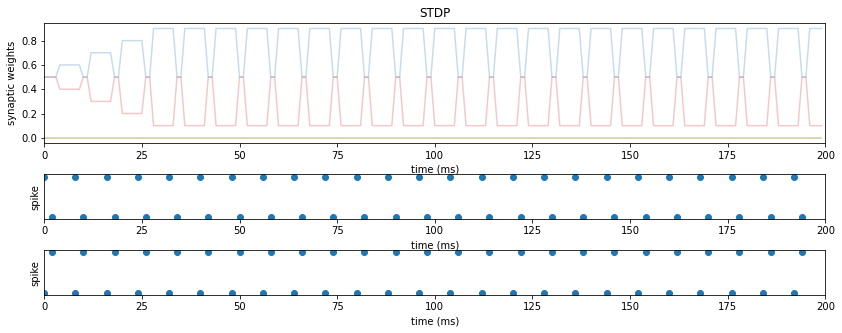

In [9]:
pre_clamps  = torch.tensor([[True,False],[False,True]])
post_clamps = torch.tensor([[False,True],[True,False]])

net.reset()

def run():
    for i in range(2):
        net.progress(external_inputs = {
            'pre' : {'clamps': pre_clamps[i] , 'unclamps': ~pre_clamps[i] },
            'post': {'clamps': post_clamps[i], 'unclamps': ~post_clamps[i]},
        })
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })
    for i in range(4):
        net.progress(external_inputs = {
            'pre' : {'unclamps': torch.tensor(True)},
            'post': {'unclamps': torch.tensor(True)},
        })

sim = Simulator(run)
sim.simulate(times=25)

plt.figure(figsize=(14,5))
md = MatplotlibDashboard([
        ['W'],
        ['W'],
        ['S2'],
        ['S1'],
    ], hspace=.7, wspace=.3)

net['pre'].plot_spikes(md['S1'])
net['post'].plot_spikes(md['S2'])
net['post']['post_LinearDendrite_0'].plot_synaptic_weights(md['W'])
md['W'].set_title('STDP')
plt.show()